## 06.14

. Mover el codigo de Experimento a modulo

## 05.29

- definir API para realizar un experimento
    # En un experimento se puede configurar
    # - el grafo del sistema
    # - la funcion de como actualizan los agentes su precio
    # - el numero de pasos de la simulacion
    # - las metricas para evaluar sobre el grafo en cada paso

#### To Do

- [ ] Integrar la funcion de update
- [ ] Definir como integrar sobre que nodos iterar en cada step
- [ ] Definir metodo para guardar los resultados del experimento 

In [1]:
import init # Necesario para importar agentes
from agentes import Experimento

In [2]:
# mantener los imports siempre arriba
from networkx import DiGraph
from networkx.drawing import draw

In [3]:
grafo = DiGraph({"a":["b","c"], "b":["e"],"c":["d"],"d":["b"]})

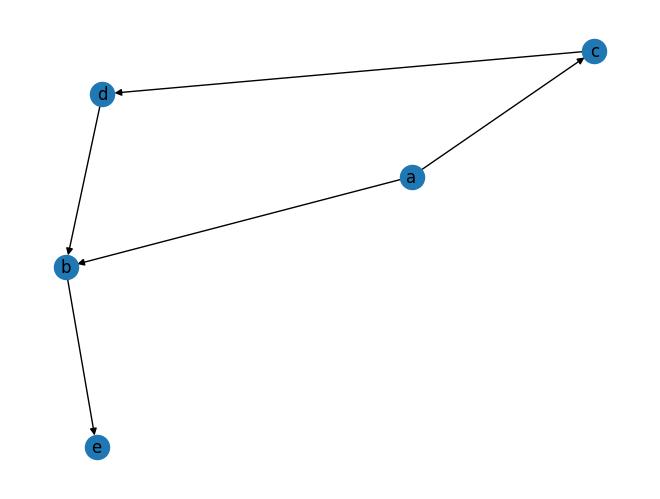

In [4]:
draw(grafo, with_labels=True)

In [5]:
def ejemplo_de_update(nodo, inflacion=0.0):
    nodo.precio *= 1.1 # aumenta el 10%
    return nodo.precio

In [6]:
def update_de_debugging(nodo, inflacion=0.0):
    print(nodo)

In [7]:
experimento = Experimento(grafo,update_de_debugging)
experimento

{'id_grafo': 152843711147, 'step': 0, 'metricas': {}}

In [8]:
experimento.step()

In [9]:
experimento

{'id_grafo': 152843711147, 'step': 1, 'metricas': {}}

In [10]:
def contar_nodos(grafo):
    return len(grafo)

metricas = {"cuenta":contar_nodos}
experimento_con_metricas = Experimento(grafo,update_de_debugging, metricas)
experimento_con_metricas.step(3)
experimento_con_metricas

{'id_grafo': 152843711147, 'step': 3, 'metricas': {'cuenta': [5, 5, 5]}}